In [56]:
#importing all the required libraries 
!pip install missingpy
import io
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from missingpy import KNNImputer
from sklearn.decomposition import PCA
import fancyimpute
from fancyimpute import KNN
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from sklearn import decomposition

In [3]:
#Uploading file to Google Colab
uploaded = files.upload()

Saving secom.data to secom.data


In [0]:
#Reading that uploaded file to colab
data_secom = pd.read_csv(io.BytesIO(uploaded['secom.data']),delimiter=" ",header=None)
# Dataset is now stored in a Pandas Dataframe

### Data Exploration

In [144]:
print(data_secom.head())
print(data_secom.shape)

       0        1          2          3    ...     586     587     588       589
0  3030.93  2564.00  2187.7333  1411.1265  ...     NaN     NaN     NaN       NaN
1  3095.78  2465.14  2230.4222  1463.6606  ...  0.0096  0.0201  0.0060  208.2045
2  2932.61  2559.94  2186.4111  1698.0172  ...  0.0584  0.0484  0.0148   82.8602
3  2988.72  2479.90  2199.0333   909.7926  ...  0.0202  0.0149  0.0044   73.8432
4  3032.24  2502.87  2233.3667  1326.5200  ...  0.0202  0.0149  0.0044   73.8432

[5 rows x 590 columns]
(1567, 590)


In [145]:
print(data_secom.describe())
#print(data_secom.dtypes)

               0            1    ...          588          589
count  1561.000000  1560.000000  ...  1566.000000  1566.000000
mean   3014.452896  2495.850231  ...     0.005283    99.670066
std      73.621787    80.407705  ...     0.002867    93.891919
min    2743.240000  2158.750000  ...     0.001000     0.000000
25%    2966.260000  2452.247500  ...     0.003300    44.368600
50%    3011.490000  2499.405000  ...     0.004600    71.900500
75%    3056.650000  2538.822500  ...     0.006400   114.749700
max    3356.350000  2846.440000  ...     0.028600   737.304800

[8 rows x 590 columns]


In [146]:
print(data_secom.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, 0 to 589
dtypes: float64(590)
memory usage: 7.1 MB
None


### Removing Duplicates if any

In [147]:
def duplicateCheck(data):
  data = data.drop_duplicates(keep = "first")
  return data

print("shape before duplicateCheck -- ",data_secom.shape)
data_secom=duplicateCheck(data_secom)
print("shape after duplicateCheck -- ",data_secom.shape)

shape before duplicateCheck --  (1567, 590)
shape after duplicateCheck --  (1567, 590)


* There are no duplicate observations

### Handling Missing Values

In [148]:
data_secom.isnull().sum().sort_values(ascending=False).head(5)

158    1429
157    1429
292    1429
293    1429
220    1341
dtype: int64

In [0]:
def knnImputation(data):
  numColumnNames = np.array(data.select_dtypes(include=["int64","float"]).columns)
  catColumnNames = np.array(data.select_dtypes(include=["object"]).columns)
  remColumnNames = np.array(data.select_dtypes(exclude=["int64","float","object"]).columns)

  catData = data[catColumnNames]
  numData = data[numColumnNames]
  remData = data[remColumnNames]
  
  imputer = KNNImputer()
  print("-----KNN Imputation-----")
  num_imputed=pd.DataFrame(data=KNN(3).fit_transform(numData), columns=numColumnNames, index=numData.index)
  

  data = pd.concat([data[catColumnNames],num_imputed,data[remColumnNames]], axis=1)
  return data


# print("shape before knnImputation -- ",data_secom.isnull().sum().sort_values(ascending=False).head(5))
# #secom_data = knnImputation(data_secom)
# print("shape after knnImputation -- ",data_secom.isnull().sum().sort_values(ascending=False).head(5))

In [150]:
def missingValueImputation(data):
  index=0
  type_l=list(data.dtypes)
  column_names=data.columns
  print("-----mean,mode,median imputation-----")
  
  for column_type in type_l:
    if column_type=='int64' or column_type=='float64':
      data[column_names[index]]=data[column_names[index]].fillna(data[column_names[index]].mean())
    else:
        data[column_names[index]]=data[column_names[index]].fillna(data[column_names[index]].mode().iloc[0])
    index=index+1   

  return data


print("shape before mean,mode imputation -- ",data_secom.isnull().sum().sort_values(ascending=False).head(5))
data_secom = missingValueImputation(data_secom)
print("shape after mean,mode imputation -- ",data_secom.isnull().sum().sort_values(ascending=False).head(5))

print(data_secom.head(3))

shape before mean,mode imputation --  158    1429
157    1429
292    1429
293    1429
220    1341
dtype: int64
-----mean,mode,median imputation-----
shape after mean,mode imputation --  589    0
184    0
200    0
199    0
198    0
dtype: int64
       0        1          2    ...       587       588         589
0  3030.93  2564.00  2187.7333  ...  0.016475  0.005283   99.670066
1  3095.78  2465.14  2230.4222  ...  0.020100  0.006000  208.204500
2  2932.61  2559.94  2186.4111  ...  0.048400  0.014800   82.860200

[3 rows x 590 columns]


#### Removing Variables with uniqueness percent more than 80%

In [151]:
#Removing Unique Value Variables with uniqueness percent more than 80%
def uniqueValRemoval(data):
    numColumnNames = np.array(data.select_dtypes(include=["int64","float"]).columns)
    remColumnNames = np.array(data.select_dtypes(exclude=["int64","float","object"]).columns)

    numData = data[numColumnNames]
    remData = data[remColumnNames]

    for column in numData.columns.values:
        col = len(set(numData[column]))/numData.shape[0]
        if col > 0.79:
            numData.drop(column, axis=1, inplace=True)
    data = pd.concat([numData,data[remColumnNames]], axis=1)
    return data
    
print("shape before  -- ",data_secom.shape)
data_secom = uniqueValRemoval(data_secom)
print("shape after   -- ",data_secom.shape)

shape before  --  (1567, 590)
shape after   --  (1567, 448)


#### Scaling Data

In [152]:
data_secom_std = StandardScaler().fit_transform(data_secom)
pd.DataFrame(data_secom_std).head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447
0,-0.436273,0.033555,-0.050580,0.0,-0.563790,0.266269,0.509826,1.128417,-0.381543,-1.515481,0.0,-0.285874,0.174798,-0.146683,0.735468,-1.737835,-0.874088,-2.887741,-1.522972,-0.842506,-0.636809,-0.958086,0.411076,0.029074,-0.115420,-0.029082,0.305404,0.266364,-0.645798,-0.277120,0.496231,0.0,0.0,0.0,-0.017703,0.041645,-0.862453,0.419433,-0.195486,1.322854,...,-0.390190,-0.900504,-0.362715,-0.372703,-0.983635,-0.306118,-0.555732,-0.811432,-0.347493,0.470027,0.560419,0.610275,0.531334,-8.200826e-14,-3.212172e-14,-3.452799e-14,1.544290e-14,2.177526e-14,2.448264e-14,-1.913066e-14,-9.956414e-15,0.190142,0.034410,-0.226018,-0.120518,-0.226665,-0.031418,-0.229797,-0.135520,-1.885396e-15,-5.735472e-16,4.436053e-16,5.175234e-16,0.118699,-0.204890,-0.093207,-2.528283e-15,-2.759188e-15,-6.054371e-15,-1.665950e-15
1,1.017137,0.153067,-0.060045,0.0,0.198217,0.322244,0.456999,0.022582,-1.608247,-0.132859,0.0,-0.111557,-0.093159,-1.348004,-0.322234,0.526715,0.400516,0.604455,-0.311560,-0.243685,0.791224,-0.213439,0.624756,0.065119,-0.106092,-0.065126,-4.283560,1.539908,-0.310484,0.433389,-0.247731,0.0,0.0,0.0,-0.054158,0.058456,-0.123389,0.522427,-0.315410,1.043896,...,0.091170,-0.223469,0.079904,0.024633,-0.291884,-0.008702,-0.141962,-0.259298,0.093015,-0.377168,-0.751295,-0.677922,-0.745572,-8.200826e-14,-3.212172e-14,-3.452799e-14,1.544290e-14,2.177526e-14,2.448264e-14,-1.913066e-14,-9.956414e-15,0.256816,1.205944,-0.261137,-0.323417,-0.265730,-0.406218,-0.263493,-0.460054,-1.632264e+00,5.406668e-01,3.089342e-01,2.007880e+00,0.530203,0.406679,0.444706,-9.601744e-01,4.118532e-01,2.501244e-01,1.156689e+00
2,-0.481289,0.686213,-0.047906,0.0,-0.906210,0.255074,-0.260907,0.327183,0.124204,-0.229321,0.0,-0.335679,0.273326,0.433058,0.008033,0.610692,0.480807,0.756338,-0.684304,-0.080571,-0.326896,-0.286664,-0.224233,-0.363526,-0.172705,0.363519,-1.258029,-4.712242,-0.036961,-2.242749,0.888711,0.0,0.0,0.0,-1.949828,-1.521760,3.105153,-2.199565,-1.082928,-0.070761,...,-0.780939,-0.188183,-0.306382,-0.757351,-0.270752,-0.234965,-1.078814,-0.245007,-0.283718,6.050772,0.229013,0.986646,-0.396160,6.253138e-01,2.021302e+00,-2.234265e+00,6.463483e+00,-2.343664e+00,6.590016e+00,-2.253903e+00,5.144841e+00,0.257279,-0.263745,-0.199823,-0.633805,-0.188395,-0.600996,-0.205046,-0.590505,4.997564e+00,5.219045e+00,4.809624e+00,-2.744816e-01,-1.262780,0.022264,0.014375,2.991151e+00,3.627063e+00,3.321419e+00,-1.791486e-01


#### Covariance Matrix

In [153]:
co_matrix = np.matmul(data_secom_std.T,data_secom_std)
print(pd.DataFrame(co_matrix).shape)
print(co_matrix)

(448, 448)
[[1567.          468.43070939  150.26063574 ...  -45.98345727
   -48.29226299  -51.53858994]
 [ 468.43070939 1567.          -91.64313851 ...  -61.32000821
   -52.7220234  -125.89371108]
 [ 150.26063574  -91.64313851 1567.         ...  -48.58406411
   -40.89863419   79.7759783 ]
 ...
 [ -45.98345727  -61.32000821  -48.58406411 ... 1567.
  1526.68989519  612.40409403]
 [ -48.29226299  -52.7220234   -40.89863419 ... 1526.68989519
  1567.          609.89421083]
 [ -51.53858994 -125.89371108   79.7759783  ...  612.40409403
   609.89421083 1567.        ]]


### Eigen Values and Vectors

In [154]:
val,vec = eigh(co_matrix)
print(vec.shape)
print(val)

(448, 448)
[-7.41318960e-13 -5.95718913e-13 -3.88787950e-13 -1.35839245e-13
 -1.14318432e-13 -1.08846697e-13 -5.25448289e-14 -4.90817954e-14
 -4.36659405e-14 -3.96220726e-14 -2.43514823e-14 -2.25310354e-14
 -1.43502516e-14 -1.35435379e-14 -1.25605287e-14 -9.24025871e-15
 -4.14657125e-15 -2.51253697e-15 -2.11220001e-15 -1.08470899e-15
 -1.04223310e-15 -7.91350383e-16 -6.80543580e-16 -7.29013736e-17
 -6.50962747e-17 -4.98863962e-17 -4.66107174e-17 -4.12975152e-17
 -7.09967886e-18 -6.14886840e-19 -1.09090083e-29 -7.09091088e-30
 -6.58745078e-30 -5.78496621e-30 -5.09560855e-30 -1.46315246e-30
 -1.33855589e-30 -1.13341567e-30 -3.38967937e-31 -2.82058757e-31
 -1.11043805e-31 -2.36910145e-32  5.54896125e-32  7.99146925e-32
  1.23762875e-31  1.38824846e-31  1.76735075e-31  2.07355386e-31
  2.76635234e-31  2.92578289e-31  3.12711074e-31  5.89374843e-31
  8.67462906e-31  1.77613886e-30  2.79884550e-30  3.98721918e-30
  4.01231984e-30  4.01667790e-30  4.13896731e-30  5.38710609e-30
  6.05546392e-

### PCA

In [0]:
pca = decomposition.PCA(data_secom_std)
pca.n_components = 448
data_after_pca = pca.fit_transform(data_secom_std)

In [156]:
print(pca.explained_variance_)

[1.16819181e+01 1.12114441e+01 1.03503696e+01 8.87112509e+00
 8.01271474e+00 6.88261745e+00 6.56486892e+00 6.04551761e+00
 5.70324942e+00 5.56728044e+00 5.38166114e+00 5.27642486e+00
 5.23702726e+00 4.97232684e+00 4.80506666e+00 4.61990331e+00
 4.52498195e+00 4.35785012e+00 4.25540954e+00 4.18513141e+00
 4.06656450e+00 3.98533453e+00 3.84855569e+00 3.71141775e+00
 3.60592492e+00 3.49589525e+00 3.46251794e+00 3.37727001e+00
 3.32704869e+00 3.19592530e+00 3.15269694e+00 3.05949358e+00
 3.02592574e+00 2.94864895e+00 2.88141813e+00 2.86485133e+00
 2.82857998e+00 2.73947633e+00 2.69854073e+00 2.66774268e+00
 2.58552157e+00 2.55551995e+00 2.51138553e+00 2.41306840e+00
 2.39458182e+00 2.37769757e+00 2.31223646e+00 2.27284874e+00
 2.26717121e+00 2.22758789e+00 2.20257350e+00 2.16974441e+00
 2.12673836e+00 2.08222527e+00 2.05280776e+00 2.01657152e+00
 1.99183689e+00 1.97953397e+00 1.91455433e+00 1.90047295e+00
 1.81873087e+00 1.77877399e+00 1.76404470e+00 1.71991602e+00
 1.68945341e+00 1.660502

In [0]:
pca_variance_ratio = pca.explained_variance_ratio_
#print(pca_variance_ratio)
cum_sum = pca.explained_variance_ratio_.cumsum()

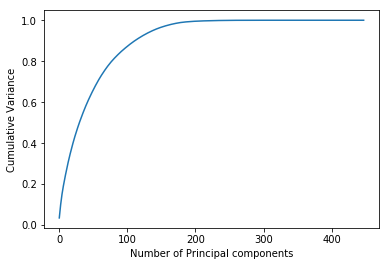

In [158]:
plt.plot(cum_sum)
plt.xlabel('Number of Principal components')
plt.ylabel('Cumulative Variance')
plt.show()

 * From the above plot, It is clear that about 175-180 PC's explains 97% of the total variance  

### Top 7 PCA's :

In [0]:
pca.n_components = 7
top7_PC = pca.fit_transform(data_secom_std)
top7_PC = pd.DataFrame(data = top7_PC,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])

In [160]:
print(top7_PC.head(10))

         PC1       PC2       PC3       PC4        PC5        PC6       PC7
0  -3.721422  0.803246 -0.684454 -5.111066  -0.706876  -0.763248  1.907183
1  -2.062812 -0.826410 -0.601408 -5.052047   1.465052   0.240227  1.084550
2  -0.696433  1.095633 -0.092085 -2.097104   0.307654  -0.099776 -0.052415
3  -7.117859  5.528154  0.667446 -1.345640 -11.049400  10.960879  7.325135
4  -2.742399  1.358254  0.090670  0.862488  -2.901231   0.160136 -0.115931
5  -3.134677  2.035217 -0.373877 -3.906683  -0.162156  -2.031996  0.645295
6  -4.763442  1.408984 -0.236927 -1.211007  -0.294178  -1.197185  0.146758
7  -1.755028  0.807090 -0.901421 -4.537623   2.112149  -0.883512 -0.387896
8 -12.976344  4.745244 -0.647062  4.508363   8.882897  -3.619363 -0.732832
9  -3.960559  1.242945 -1.064311 -6.023346   2.434281   0.522143  1.744336
